In [4]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import scipy
from scipy import stats
import numpy as np

In [203]:
rolling_window = 5

# Losing election

In [204]:
event = "Losing Election"

In [ ]:
with open(f"../data/deltas_real_fake/deltas_{rolling_window}_{event}.pkl", "rb") as f:
    df_all_losing = pickle.load(f)

In [206]:
df_sub_losing = df_all_losing[['main_union', 'case_number', 'frame_prop', 'delta_before', 'delta_after']]
df_sub_losing = df_sub_losing[~df_sub_losing['frame_prop'].str.contains("with")]

In [207]:
df_sub_losing.drop_duplicates(subset=["main_union", "case_number", "frame_prop"], inplace=True)

In [208]:
before_losing = {}
after_losing = {}
for frame in df_sub_losing['frame_prop'].unique():
    df_frame_losing = df_sub_losing[df_sub_losing['frame_prop'] == frame]
    before_losing[frame] = df_frame_losing['delta_before'].tolist()
    after_losing[frame] = df_frame_losing['delta_after'].tolist()

# Winning election

In [211]:
event = "Winning Election"

In [ ]:
with open(f"../data/deltas_real_fake/deltas_{rolling_window}_{event}.pkl", "rb") as f:
    df_all_winning = pickle.load(f)

In [213]:
df_sub_winning = df_all_winning[['main_union', 'case_number', 'frame_prop', 'delta_before', 'delta_after']]
df_sub_winning = df_sub_winning[~df_sub_winning['frame_prop'].str.contains("with")]

In [214]:
df_sub_winning.drop_duplicates(subset=["main_union", "case_number", "frame_prop"], inplace=True)

In [215]:
before_winning = {}
after_winning = {}
for frame in df_sub_winning['frame_prop'].unique():
    df_frame_winning = df_sub_winning[df_sub_winning['frame_prop'] == frame]
    before_winning[frame] = df_frame_winning['delta_before'].tolist()
    after_winning[frame] = df_frame_winning['delta_after'].tolist()

# Plot comparison

## Before

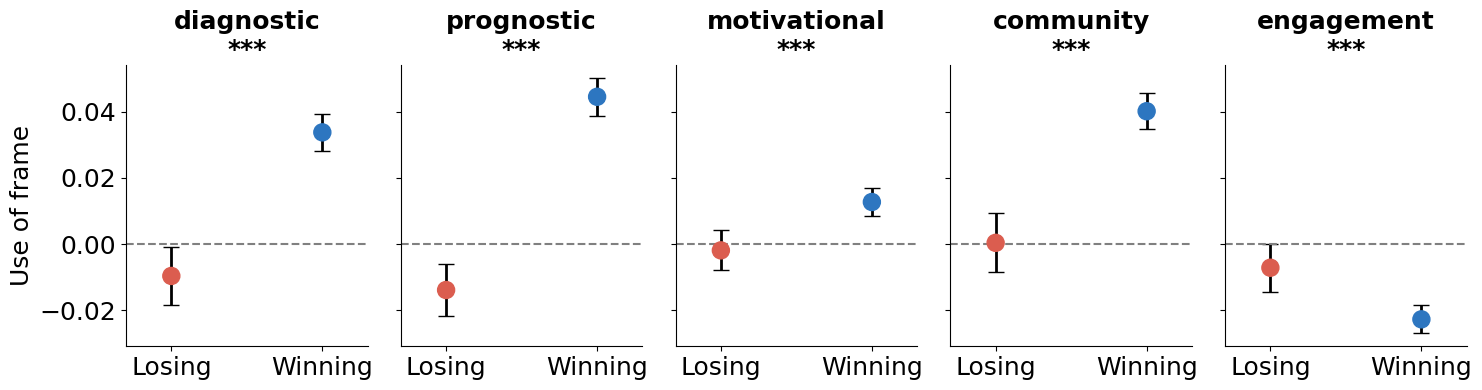

In [ ]:
n_keys = len(before_losing.keys())
n_cols = len(before_losing.keys())  
n_rows = (n_keys + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
axes = axes.flatten()  

for i, key in enumerate([
    "rolling_diagnostic_prop", "rolling_prognostic_prop", "rolling_motivational_prop",
    "rolling_community_prop", "rolling_engagement_prop"
]):
    before_losing_key = before_losing[key]
    before_winning_key = before_winning[key]

    # t-test
    t_stat, p_val = stats.ttest_ind(before_losing_key, before_winning_key, equal_var=False)

    # compute mean + 95% CI
    groups = [before_losing_key, before_winning_key]
    means, cis = [], []
    for g in groups:
        mean = np.mean(g)
        ci = stats.sem(g) * stats.t.ppf((1 + 0.95) / 2, len(g) - 1)
        means.append(mean)
        cis.append(ci)

    # plot means with CI
    axes[i].errorbar([0, 1], means, yerr=cis, fmt='o', capsize=6,
                     color='black', ecolor='black', elinewidth=2)
    axes[i].scatter([0, 1], means, c=["#DB5D4F", "#2D76C0"], s=150, zorder=3)
    axes[i].axhline(y=0, color='gray', linestyle='--')

    # formatting
    # significance stars based on p-value
    if p_val < 0.001:
        sig = '***'
    elif p_val < 0.01:
        sig = '**'
    elif p_val < 0.05:
        sig = '*'
    else:
        sig = ''

    if key == "rolling_prognotic_prop":
        key = "rolling_prognostic_prop"

    # use the star(s) in the subplot title
    axes[i].set_title(f"{key.split('_')[1]}\n{sig}", fontsize=18, weight="bold")
    axes[i].set_xlabel('')
    if i == 0:
        axes[i].set_ylabel('Use of frame', fontsize=18)
    else:
        axes[i].set_ylabel('')

    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Losing', 'Winning'], fontsize=18)
    axes[i].tick_params(axis='y', labelsize=18)

    # reduce horizontal space between points
    axes[i].set_xlim(-0.3, 1.3)

    sns.despine(ax=axes[i])

# remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# fig.suptitle('Comparison of Frame Use Before Election (Mean and 95% CI)', fontsize=24, y=1.1)
plt.savefig(f'../../plots/for-paper/usage_before.svg', bbox_inches='tight')


## After

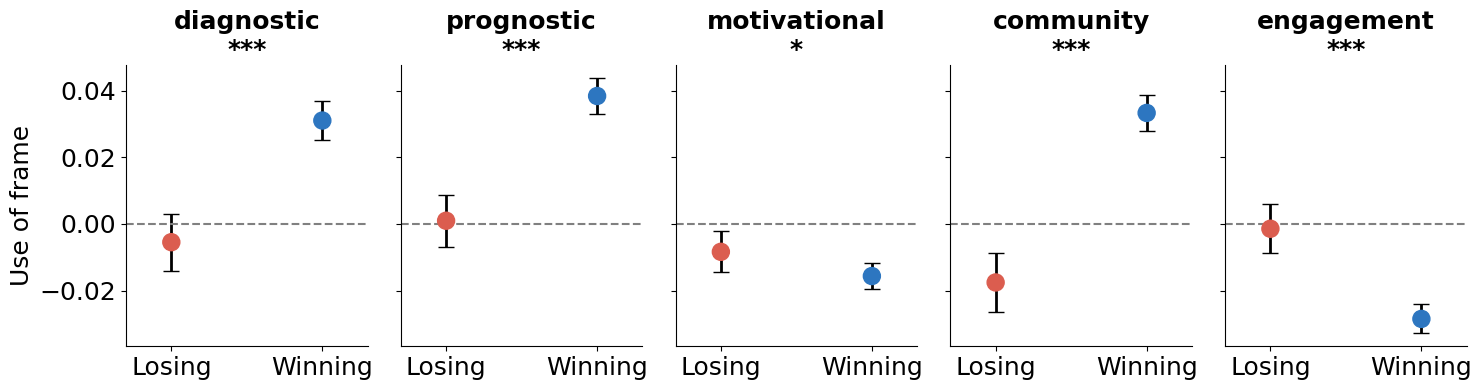

In [ ]:
n_keys = len(after_losing.keys())
n_cols = len(after_losing.keys())  
n_rows = (n_keys + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
axes = axes.flatten()  

for i, key in enumerate([
    "rolling_diagnostic_prop", "rolling_prognostic_prop", "rolling_motivational_prop",
    "rolling_community_prop", "rolling_engagement_prop"
]):
    after_losing_key = after_losing[key]
    after_winning_key = after_winning[key]

    # t-test
    t_stat, p_val = stats.ttest_ind(after_losing_key, after_winning_key, equal_var=False)

    # compute mean + 95% CI
    groups = [after_losing_key, after_winning_key]
    means, cis = [], []
    for g in groups:
        mean = np.mean(g)
        ci = stats.sem(g) * stats.t.ppf((1 + 0.95) / 2, len(g) - 1)
        means.append(mean)
        cis.append(ci)

    # plot means with CI
    axes[i].errorbar([0, 1], means, yerr=cis, fmt='o', capsize=6,
                     color='black', ecolor='black', elinewidth=2)
    axes[i].scatter([0, 1], means, c=["#DB5D4F", "#2D76C0"], s=150, zorder=3)
    axes[i].axhline(y=0, color='gray', linestyle='--')

    # formatting
    # significance stars based on p-value
    if p_val < 0.001:
        sig = '***'
    elif p_val < 0.01:
        sig = '**'
    elif p_val < 0.05:
        sig = '*'
    else:
        sig = ''

    if key == "rolling_prognotic_prop":
        key = "rolling_prognostic_prop"

    # use the star(s) in the subplot title
    axes[i].set_title(f"{key.split('_')[1]}\n{sig}", fontsize=18, weight="bold")
    axes[i].set_xlabel('')
    if i == 0:
        axes[i].set_ylabel('Use of frame', fontsize=18)
    else:
        axes[i].set_ylabel('')

    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Losing', 'Winning'], fontsize=18)
    axes[i].tick_params(axis='y', labelsize=18)

    # reduce horizontal space between points
    axes[i].set_xlim(-0.3, 1.3)

    sns.despine(ax=axes[i])

# remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
#fig.suptitle('Comparison of Frame Use After Election Outcome (Mean and 95% CI)', fontsize=24, y=1.1)
plt.savefig(f'../../plots/for-paper/usage_after.svg', bbox_inches='tight')


# Robustness

## Remove over-represented unions

In [77]:
def subsample_unions(df_losing, df_winning, random_state=0):
    # Combine both datasets
    df_all = pd.concat([df_losing, df_winning], ignore_index=True)
    df_all = df_all.drop_duplicates(subset=["main_union", "case_number"])
    
    # Count cases per union
    size_counts = df_all.groupby("main_union").size()

    # Define upper bounds (90th percentile)
    upper = size_counts.quantile(0.90)
    
    # Decide target sample size (here: clip to [lower, upper])
    target_counts = size_counts.clip(upper=upper).astype(int)
    
    # Subsample each union to its target size
    sampled = []
    for union, group in df_all.groupby("main_union"):
        target_n = target_counts.loc[union]
        if len(group) > upper:
            sampled_group = group.sample(n=target_n, random_state=random_state)
        else:
            sampled_group = group  # keep all if fewer than target
        sampled.append(sampled_group)
    df_sampled = pd.concat(sampled, ignore_index=True)
    
    # Re-split into losing and winning
    df_sub_losing = df_losing[df_losing["case_number"].isin(df_sampled["case_number"])]
    df_sub_winning = df_winning[df_winning["case_number"].isin(df_sampled["case_number"])]
    
    return df_sub_losing, df_sub_winning

In [78]:
all_results = []
for seed in range(20):
    df_sub_losing_seed, df_sub_winning_seed = subsample_unions(df_sub_losing, df_sub_winning, random_state=seed)
    df_sub_losing_seed["seed"] = seed
    df_sub_winning_seed["seed"] = seed
    all_results.append((df_sub_losing_seed, df_sub_winning_seed))

robust_df_losing = pd.concat([result[0] for result in all_results], axis=0)
robust_df_winning = pd.concat([result[1] for result in all_results], axis=0)

/var/folders/3g/c8qm42k164b6t37cxylyjjfc0000gn/T/ipykernel_26954/2612108132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_losing_seed["seed"] = seed
/var/folders/3g/c8qm42k164b6t37cxylyjjfc0000gn/T/ipykernel_26954/2612108132.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_winning_seed["seed"] = seed
/var/folders/3g/c8qm42k164b6t37cxylyjjfc0000gn/T/ipykernel_26954/2612108132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [80]:
before_losing = {}
for seed in range(20):
    robust_df_losing_seed = robust_df_losing[robust_df_losing['seed'] == seed]
    before_losing[seed] = {}
    for frame in robust_df_losing_seed['frame_prop'].unique():
        df_frame_losing = robust_df_losing_seed[robust_df_losing_seed['frame_prop'] == frame]
        before_losing[seed][frame] = df_frame_losing['delta_before'].tolist()

In [81]:
before_winning = {}
for seed in range(20):
    robust_df_winning_seed = robust_df_winning[robust_df_winning['seed'] == seed]
    before_winning[seed] = {}
    for frame in robust_df_winning_seed['frame_prop'].unique():
        df_frame_winning = robust_df_winning_seed[robust_df_winning_seed['frame_prop'] == frame]
        before_winning[seed][frame] = df_frame_winning['delta_before'].tolist()

In [ ]:
frames = [
    "rolling_diagnostic_prop", "rolling_prognostic_prop",
    "rolling_motivational_prop", "rolling_community_prop",
    "rolling_engagement_prop"
]

results = []
for seed in range(20):
    for i, key in enumerate(frames):
        before_losing_key = before_losing[seed][key]
        before_winning_key = before_winning[seed][key]

        # t-test
        t_stat, p_val = stats.ttest_ind(before_losing_key, before_winning_key, equal_var=False)

        # store results
        results.append({
            'frame': key,
            'seed': seed,
            't_stat': t_stat,
            'p_val': p_val
        })

In [83]:
results = pd.DataFrame(results)

In [84]:
# assume df is your results dataframe
summary = (
    results.groupby("frame")
      .apply(lambda g: pd.Series({
          "pct_p<0.05": (g["p_val"] < 0.05).mean() * 100,
          "pct_p<0.01": (g["p_val"] < 0.01).mean() * 100,
          "pct_p<0.001": (g["p_val"] < 0.001).mean() * 100,
          "median_t": g["t_stat"].median(),
          "median_p": g["p_val"].median(),
          "min_t": g["t_stat"].min(),
          "max_t": g["t_stat"].max(),
      }))
      .reset_index()
)

# nice formatting
summary["pct_p<0.05"] = summary["pct_p<0.05"].map("{:.0f}%".format)
summary["pct_p<0.01"] = summary["pct_p<0.01"].map("{:.0f}%".format)
summary["pct_p<0.001"] = summary["pct_p<0.001"].map("{:.0f}%".format)
summary["median_t"] = summary["median_t"].map("{:.2f}".format)
summary["median_p"] = summary["median_p"].map("{:.1e}".format)
summary["range_t"] = summary.apply(lambda r: f"[{r['min_t']:.2f}, {r['max_t']:.2f}]", axis=1)

summary = summary[["frame","pct_p<0.05","pct_p<0.01","pct_p<0.001","median_t","median_p","range_t"]]

summary

,frame,pct_p<0.05,pct_p<0.01,pct_p<0.001,median_t,median_p,range_t
0,rolling_community_prop,100%,100%,100%,-4.97,6.9e-07,"[-5.78, -4.47]"
1,rolling_diagnostic_prop,100%,100%,95%,-3.94,8.2e-05,"[-4.38, -3.10]"
2,rolling_engagement_prop,20%,0%,0%,1.67,9.4e-02,"[1.07, 2.11]"
3,rolling_motivational_prop,0%,0%,0%,-0.59,5.5e-01,"[-1.40, 0.53]"
4,rolling_prognotic_prop,100%,100%,100%,-5.23,1.8e-07,"[-5.69, -4.37]"


# n_days = 3 check

In [189]:
rolling_window = 3

## Losing election

In [190]:
event = "Losing Election"

In [ ]:
with open(f"../data/deltas_real_fake/deltas_{rolling_window}_{event}.pkl", "rb") as f:
    df_all_losing = pickle.load(f)

In [192]:
df_sub_losing = df_all_losing[['main_union', 'case_number', 'frame_prop', 'delta_before', 'delta_after']]
df_sub_losing = df_sub_losing[~df_sub_losing['frame_prop'].str.contains("with")]

In [193]:
df_sub_losing.drop_duplicates(subset=["main_union", "case_number", "frame_prop"], inplace=True)

In [194]:
before_losing = {}
after_losing = {}
for frame in df_sub_losing['frame_prop'].unique():
    df_frame_losing = df_sub_losing[df_sub_losing['frame_prop'] == frame]
    before_losing[frame] = df_frame_losing['delta_before'].tolist()
    after_losing[frame] = df_frame_losing['delta_after'].tolist()

## Winning election

In [195]:
event = "Winning Election"

In [ ]:
with open(f"../data/deltas_real_fake/deltas_{rolling_window}_{event}.pkl", "rb") as f:
    df_all_winning = pickle.load(f)

In [197]:
df_sub_winning = df_all_winning[['main_union', 'case_number', 'frame_prop', 'delta_before', 'delta_after']]
df_sub_winning = df_sub_winning[~df_sub_winning['frame_prop'].str.contains("with")]

In [198]:
df_sub_winning.drop_duplicates(subset=["main_union", "case_number", "frame_prop"], inplace=True)

In [199]:
before_winning = {}
after_winning = {}
for frame in df_sub_winning['frame_prop'].unique():
    df_frame_winning = df_sub_winning[df_sub_winning['frame_prop'] == frame]
    before_winning[frame] = df_frame_winning['delta_before'].tolist()
    after_winning[frame] = df_frame_winning['delta_after'].tolist()

## Plot comparison

### Before

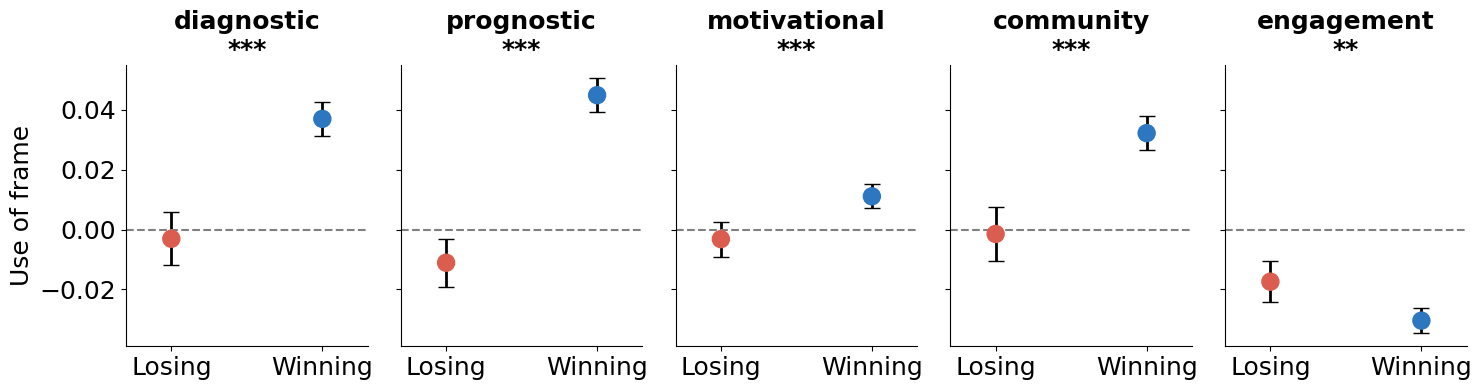

In [ ]:
n_keys = len(before_losing.keys())
n_cols = len(before_losing.keys())  
n_rows = (n_keys + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
axes = axes.flatten()  

for i, key in enumerate([
    "rolling_diagnostic_prop", "rolling_prognostic_prop", "rolling_motivational_prop",
    "rolling_community_prop", "rolling_engagement_prop"
]):
    before_losing_key = before_losing[key]
    before_winning_key = before_winning[key]

    # t-test
    t_stat, p_val = stats.ttest_ind(before_losing_key, before_winning_key, equal_var=False)

    # compute mean + 95% CI
    groups = [before_losing_key, before_winning_key]
    means, cis = [], []
    for g in groups:
        mean = np.mean(g)
        ci = stats.sem(g) * stats.t.ppf((1 + 0.95) / 2, len(g) - 1)
        means.append(mean)
        cis.append(ci)

    # plot means with CI
    axes[i].errorbar([0, 1], means, yerr=cis, fmt='o', capsize=6,
                     color='black', ecolor='black', elinewidth=2)
    axes[i].scatter([0, 1], means, c=["#DB5D4F", "#2D76C0"], s=150, zorder=3)
    axes[i].axhline(y=0, color='gray', linestyle='--')

    # formatting
    # significance stars based on p-value
    if p_val < 0.001:
        sig = '***'
    elif p_val < 0.01:
        sig = '**'
    elif p_val < 0.05:
        sig = '*'
    else:
        sig = ''

    if key == "rolling_prognotic_prop":
        key = "rolling_prognostic_prop"

    # use the star(s) in the subplot title
    axes[i].set_title(f"{key.split('_')[1]}\n{sig}", fontsize=18, weight="bold")
    axes[i].set_xlabel('')
    if i == 0:
        axes[i].set_ylabel('Use of frame', fontsize=18)
    else:
        axes[i].set_ylabel('')

    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Losing', 'Winning'], fontsize=18)
    axes[i].tick_params(axis='y', labelsize=18)

    # reduce horizontal space between points
    axes[i].set_xlim(-0.3, 1.3)

    sns.despine(ax=axes[i])

# remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# fig.suptitle('Comparison of Frame Use Before Election Outcome (Mean and 95% CI)', fontsize=24, y=1.1)
plt.savefig(f'../../plots/for-paper/usage_before_days3.svg', bbox_inches='tight')


### After

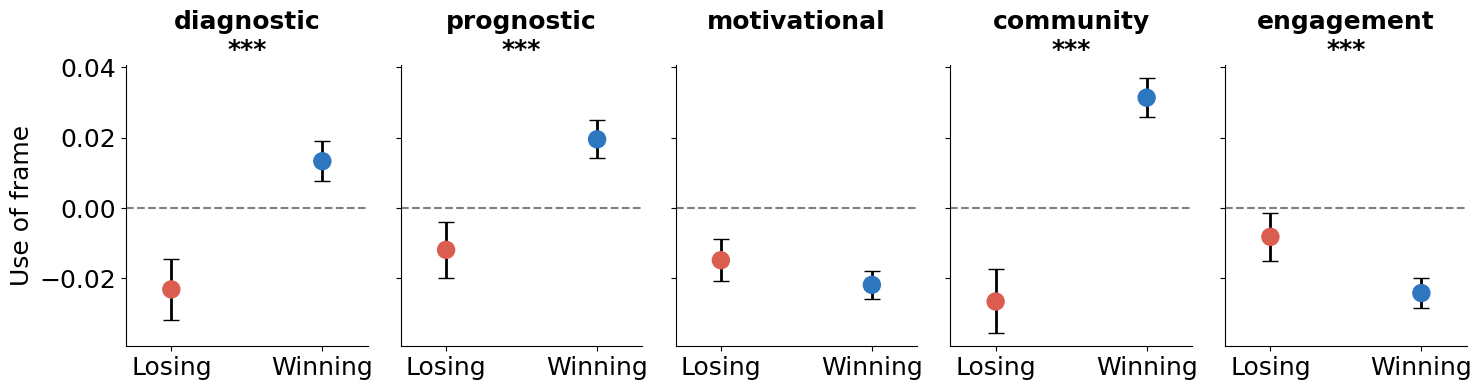

In [ ]:
n_keys = len(after_losing.keys())
n_cols = len(after_losing.keys())  
n_rows = (n_keys + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
axes = axes.flatten()  

for i, key in enumerate([
    "rolling_diagnostic_prop", "rolling_prognostic_prop", "rolling_motivational_prop",
    "rolling_community_prop", "rolling_engagement_prop"
]):
    after_losing_key = after_losing[key]
    after_winning_key = after_winning[key]

    # t-test
    t_stat, p_val = stats.ttest_ind(after_losing_key, after_winning_key, equal_var=False)

    # compute mean + 95% CI
    groups = [after_losing_key, after_winning_key]
    means, cis = [], []
    for g in groups:
        mean = np.mean(g)
        ci = stats.sem(g) * stats.t.ppf((1 + 0.95) / 2, len(g) - 1)
        means.append(mean)
        cis.append(ci)

    # plot means with CI
    axes[i].errorbar([0, 1], means, yerr=cis, fmt='o', capsize=6,
                     color='black', ecolor='black', elinewidth=2)
    axes[i].scatter([0, 1], means, c=["#DB5D4F", "#2D76C0"], s=150, zorder=3)
    axes[i].axhline(y=0, color='gray', linestyle='--')

    # formatting
    # significance stars based on p-value
    if p_val < 0.001:
        sig = '***'
    elif p_val < 0.01:
        sig = '**'
    elif p_val < 0.05:
        sig = '*'
    else:
        sig = ''

    if key == "rolling_prognotic_prop":
        key = "rolling_prognostic_prop"

    # use the star(s) in the subplot title
    axes[i].set_title(f"{key.split('_')[1]}\n{sig}", fontsize=18, weight="bold")
    axes[i].set_xlabel('')
    if i == 0:
        axes[i].set_ylabel('Use of frame', fontsize=18)
    else:
        axes[i].set_ylabel('')

    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Losing', 'Winning'], fontsize=18)
    axes[i].tick_params(axis='y', labelsize=18)

    # reduce horizontal space between points
    axes[i].set_xlim(-0.3, 1.3)

    sns.despine(ax=axes[i])

# remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# fig.suptitle('Comparison of Frame Use After Election Outcome (Mean and 95% CI)', fontsize=24, y=1.1)
plt.savefig(f'../../plots/for-paper/usage_after_days3.svg', bbox_inches='tight')
